# Clean

> Create functions to return cleaned and processed versions of the kidney datasets

In [ ]:
#| default_exp clean

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#| export
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# For Imputation and testing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind, chi2_contingency

In [ ]:
if os.getcwd().split('/')[-1] == 'nbs':
    os.chdir('../')

Below are all the files in the phenotypes directory.
We will be using the
1. full_pheno.csv
2. Legend_Oct2012_PhenoDataset_CreatinineDataNumbers_2017_04_18.xlsx

The others are incomplete versions of the full_pheno.csv.

In [ ]:
%ls 'data/interim/phenotypes'

full_pheno.csv
Legend_Oct2012_PhenoDataset_CreatinineDataNumbers_2017_04_18.xlsx
Oct2012_Pheno_With_PCs.csv
simple_dcu_pheno.csv
UKIRTC.iGeneTRAiN.phenotype.data.csv
ukirtc_phenotypes_master.xlsx


## Legend


In [ ]:
#| export
def legend():
    ''' 
    This returns a dictionary of the meanings of many value present in the dataset.
    '''
    # import all legend sheets
    pheno_path = 'data/interim/phenotypes/'
    file = 'Legend_Oct2012_PhenoDataset_CreatinineDataNumbers_2017_04_18.xlsx'
    df_legend1 = pd.read_excel(pheno_path + file, sheet_name=1)
    df_legend2 = pd.read_excel(pheno_path + file, sheet_name=2)

    # Setting column values
    df_legend1.columns = df_legend2.columns = ['Value', 'Description']

    # Combining legends together
    df_legend = pd.concat([df_legend1, df_legend2])

    # Creating dictionary
    dict_legend = dict(zip(df_legend.Value, df_legend.Description))
    
    return dict_legend

Here is an example of using the legend function

In [ ]:
#| export
dict_legend = legend()

/users/k2252991/miniconda3/envs/db/lib/python3.8/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


Here is an example of using the dictionary

In [ ]:
dict_legend[522]

'Cerebro-vascular accident'

## Pheno

In [ ]:
#| export
df_pheno = pd.read_csv('data/interim/phenotypes/full_pheno.csv')

We will take a look at the head of the data. There are 157 columns (> 20) so the output is compressed

In [ ]:
#| hide
df_pheno.head()

,RECIPIENT_IID,DONOR_IID,TX_SURV,TX_CENS,REC_AGE,DON_AGE,REC_SEX,DON_SEX,GRAFT_NO,PRD,...,D_HLA_SECOND_C_broad,D_HLA_SECOND_C_SPLT,D_HLA_FIRST_DR_broad,D_HLA_FIRST_DR_split,D_HLA_SECOND_DR_broad,D_HLA_SECOND_DR_split,D_HLA_FIRST_DQ_broad,D_HLA_FIRST_DQ_split,D_HLA_SECOND_DQ_broad,D_HLA_SECOND_DQ_split
0,4493914504_R01C01,4493914504_R01C02,3571,1,54,25,2,2,1,224.0,...,Cw17,NaN,DR1,NaN,DR7,NaN,DQ1,DQ5,DQ3,DQ9
1,4493914504_R02C01,4493914504_R02C02,3642,1,35,37,1,1,1,212.0,...,NaN,NaN,DR2,DR15,DR4,NaN,DQ1,DQ6,DQ3,DQ7
2,4493914658_R02C01,4493914658_R02C02,3206,1,53,22,2,2,1,241.0,...,Cw7,NaN,DR3,DR17,DR5,DR12,DQ1,DQ6,DQ3,DQ7
3,4493914855_R01C01,4493914855_R01C02,962,1,33,48,1,2,1,282.0,...,Cw7,NaN,DR3,DR17,DR5,DR11,DQ2,NaN,DQ3,DQ7
4,4506324013_R01C01,4506324013_R01C02,1038,1,61,39,1,1,1,212.0,...,Cw7,NaN,DR4,NaN,DR7,NaN,DQ3,DQ8,DQ3,DQ9


Below we see that there are 2104 rows. Unfortunately our key variables like eGFR_1_year and eGRF_5_year have only 1646 and 1326 respectively. The principal components (PCs) and polygenic risk scores (PRSs) have over 2000 each. PRD also has 1389 non-null. 

Most variables will not be used. For example variables from 95 onward will be removed. This is because the first group relates to the drugs taken post transplant (not available prior to transplant) and second group relates to HLA information which is contained within HLA mismatches so they are redundent.

In [ ]:
#| hide
df_pheno.iloc[:,:100].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2104 entries, 0 to 2103
Data columns (total 100 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   RECIPIENT_IID         2104 non-null   object 
 1   DONOR_IID             2104 non-null   object 
 2   TX_SURV               2104 non-null   int64  
 3   TX_CENS               2104 non-null   int64  
 4   REC_AGE               2104 non-null   int64  
 5   DON_AGE               2104 non-null   int64  
 6   REC_SEX               2104 non-null   int64  
 7   DON_SEX               2104 non-null   int64  
 8   GRAFT_NO              2104 non-null   int64  
 9   PRD                   1389 non-null   float64
 10  DIAB                  1990 non-null   float64
 11  SERUM_12              1646 non-null   float64
 12  SERUM_60              1326 non-null   float64
 13  DON_COD               2104 non-null   int64  
 14  RECIP_CT              2104 non-null   object 
 15  serumfinal          

In [ ]:
#| hide
df_pheno.iloc[:,100:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2104 entries, 0 to 2103
Data columns (total 57 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   OKI_0                  1427 non-null   float64
 1   P_0                    1434 non-null   float64
 2   T_0                    1429 non-null   float64
 3   A_3                    1463 non-null   float64
 4   C_3                    1475 non-null   float64
 5   S_3                    182 non-null    float64
 6   O_3                    1397 non-null   float64
 7   P_3                    1300 non-null   float64
 8   M_3                    1201 non-null   float64
 9   T_3                    1201 non-null   float64
 10  A_12                   1499 non-null   float64
 11  C_12                   1515 non-null   float64
 12  S_12                   175 non-null    float64
 13  O_12                   1418 non-null   float64
 14  P_12                   1354 non-null   float64
 15  M_12

Using describe we find that there are some duplicate recipient and donor ids, this means that someone gave or received a kidney twice. Survival in day ranges from 0 to 9038 (24 years, 9 months). 23% of transplant are censored.

Recipient Age ranges from 18 to 79, with a mean of 45.66 and standard deviation of 13.32.
Donor Age ranges from 0 to 81 with a mean of 43.05 and standard deviation of 15.43.

Proportion of Recipients female is 36.36% 
Proportion of Donors female is 42.63%

PRD needs to be converted to a categorical variable with each variable being explicit.
Diabetes Prevalence is 26.16% in Recipients.

Creatinine Serum at 12 months mean is 151.09 and standard deviation 61.
Creatinine Serum at 60 months mean is 158.63 with standard deviation 78.10
This shows an increase over time.

Donor Cause of Death (COD) needs to be converted to a categorical variable.

Recipient Transplant Centre has 22 unique values with CH being most common with 299 occurances.

The Final Creatinine Serum measurement is the same as Serum at 60 months.

eGFR at 1 year has mean 51.57 with standard deviation of 18.50.
eGFR at 5 year has mean 50.96 with standard deviation of 20.60.
There is not much change because there is survivorship bias where only those with healthy kidneys are measured. Unhealthy kidneys are not measured.

delta eGFR has a negative mean. It appears to be centred around zero.

The PCs are all centres around zero with not much deviation.

The PRSs are centred are zero and have greater deviation than the PCs.

GDate is the date of the transplant. Need to convert to date

In [ ]:
#| hide
df_pheno.iloc[:,:20].describe(include=[object, int, float])

,RECIPIENT_IID,DONOR_IID,TX_SURV,TX_CENS,REC_AGE,DON_AGE,REC_SEX,DON_SEX,GRAFT_NO,PRD,DIAB,SERUM_12,SERUM_60,DON_COD,RECIP_CT,serumfinal,eGFR_1_year,eGFR_5_year,delta_eGFR,REC_PC1
count,2104,2104,2104.000000,2104.000000,2104.000000,2104.000000,2104.000000,2104.000000,2104.000000,1389.000000,1990.000000,1646.000000,1326.000000,2104.000000,2104,1326.000000,1646.000000,1326.000000,1057.000000,2087.000000
unique,2097,1858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,NaN,NaN,NaN,NaN,NaN
top,CCC3_RTD1129119,CCC3_RTD1127548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CH,NaN,NaN,NaN,NaN,NaN
freq,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,299,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2953.806084,1.238118,45.661122,43.050380,1.363593,1.426331,1.109316,245.724982,0.073869,151.094168,158.631976,1.617395,NaN,158.631976,51.570951,50.961273,-1.071055,0.001915
std,NaN,NaN,1536.999743,0.426033,13.323535,15.425748,0.481148,0.494661,0.312109,29.870746,0.261624,61.655393,78.100972,0.629367,NaN,78.100972,18.500468,20.608829,14.826421,0.011718
min,NaN,NaN,0.000000,1.000000,18.000000,0.000000,1.000000,1.000000,1.000000,200.000000,0.000000,56.000000,53.000000,1.000000,NaN,53.000000,5.682882,4.584922,-59.107876,-0.029969
25%,NaN,NaN,1860.750000,1.000000,36.000000,32.000000,1.000000,1.000000,1.000000,219.000000,0.000000,112.000000,113.000000,1.000000,NaN,113.000000,38.552914,36.192293,-8.850278,-0.007022
50%,NaN,NaN,2833.000000,1.000000,46.000000,45.000000,1.000000,1.000000,1.000000,241.000000,0.000000,138.000000,142.000000,2.000000,NaN,142.000000,50.395448,49.188321,-0.783980,-0.000884
75%,NaN,NaN,3911.000000,1.000000,56.000000,55.000000,2.000000,2.000000,1.000000,280.000000,0.000000,172.000000,179.750000,2.000000,NaN,179.750000,62.632673,63.448000,7.668555,0.008705


In [ ]:
#| hide
df_pheno.iloc[:,20:40].describe(include=[object, int, float])

,REC_PC2,REC_PC3,REC_PC4,REC_PC5,REC_PC6,REC_PC7,REC_PC8,REC_PC9,REC_PC10,DON_PC1,DON_PC2,DON_PC3,DON_PC4,DON_PC5,DON_PC6,DON_PC7,DON_PC8,DON_PC9,DON_PC10,REC_Hypertension_PRS
count,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2081.000000,2081.000000,2081.000000,2081.000000,2081.000000,2081.000000,2081.000000,2081.000000,2081.000000,2081.000000,2087.000000
mean,-0.000201,-0.000113,-0.000108,-0.001769,0.000381,0.000378,-0.000218,-0.000661,0.000338,0.002055,-0.000265,-0.000007,-0.000207,-0.001545,0.000670,0.000284,0.000134,-0.000560,0.000135,-0.044857
std,0.003544,0.003468,0.003258,0.004317,0.008736,0.008424,0.006477,0.006943,0.008861,0.011397,0.003548,0.003474,0.003303,0.004181,0.008755,0.006717,0.007657,0.008151,0.007520,0.970444
min,-0.014222,-0.016330,-0.011153,-0.033357,-0.137767,-0.099212,-0.070746,-0.113704,-0.164863,-0.030062,-0.011336,-0.016910,-0.010552,-0.024006,-0.095032,-0.055227,-0.090686,-0.117357,-0.121905,-3.528943
25%,-0.002632,-0.002427,-0.002227,-0.004599,-0.003284,-0.003514,-0.003580,-0.004246,-0.003178,-0.006803,-0.002628,-0.002279,-0.002464,-0.004283,-0.003020,-0.003386,-0.003412,-0.004022,-0.003174,-0.717042
50%,-0.000259,-0.000051,-0.000135,-0.001635,0.000910,0.000246,-0.000079,-0.000793,0.000223,-0.000810,-0.000259,-0.000027,-0.000263,-0.001444,0.000861,-0.000012,0.000240,-0.000483,0.000182,-0.021783
75%,0.002239,0.002236,0.002113,0.000940,0.004615,0.004114,0.003275,0.002924,0.003680,0.009339,0.002138,0.002263,0.002009,0.001215,0.004584,0.003781,0.003542,0.003114,0.003624,0.615619
max,0.012484,0.010954,0.009535,0.012030,0.136245,0.175438,0.094729,0.089333,0.189112,0.035949,0.014710,0.011656,0.009839,0.019291,0.120256,0.067558,0.179583,0.111460,0.105814,4.080345


In [ ]:
#| hide
df_pheno.iloc[:,40:60].describe(include=[object, int, float])

,DON_Hypertension_PRS,REC_Albuminuria_PRS,DON_Albuminuria_PRS,REC_egfr_PRS,DON_egfr_PRS,REC_delta_egfr_PRS,DON_delta_egfr_PRS,REC_Stroke_PRS,DON_Stroke_PRS,REC_IA_PRS,DON_IA_PRS,REC_HAKV_PRS,DON_HAKV_PRS,REC_PKD_PRS,DON_PKD_PRS,REC_KV_PRS,DON_KV_PRS,R_GT,D_GT,RAGE
count,2081.000000,2087.000000,2081.000000,2087.000000,2081.000000,2087.000000,2081.000000,2087.000000,2081.000000,2087.000000,2081.000000,2087.000000,2081.000000,2087.000000,2081.000000,2087.000000,2081.000000,2104.0,2104.0,2104.000000
mean,0.118698,0.005557,0.037366,-0.047395,0.055370,0.019132,-0.006549,0.054234,0.081161,-0.007262,0.145174,-0.004794,0.016353,0.024963,0.121222,-0.013748,0.000795,1.0,1.0,45.661122
std,1.026364,0.980346,0.994982,1.005169,0.981347,1.011134,1.003248,0.990628,1.003128,0.978113,1.009259,0.987402,0.988176,1.020332,0.978345,0.999405,0.966742,0.0,0.0,13.323535
min,-3.990416,-3.462323,-2.859917,-3.685787,-3.636825,-3.027887,-3.769361,-3.209226,-3.274271,-3.432464,-2.808270,-3.179627,-3.134434,-3.171947,-3.488383,-3.748577,-3.005351,1.0,1.0,18.000000
25%,-0.580600,-0.632013,-0.644107,-0.730689,-0.632589,-0.661274,-0.664642,-0.626051,-0.553364,-0.655871,-0.543874,-0.642179,-0.646801,-0.691766,-0.532164,-0.660909,-0.645133,1.0,1.0,36.000000
50%,0.149916,0.007506,0.030285,-0.042162,0.064471,-0.001451,0.009083,0.067272,0.063715,-0.015617,0.155833,-0.009860,0.005755,-0.001614,0.108734,-0.025398,0.036326,1.0,1.0,46.000000
75%,0.815366,0.700791,0.717839,0.655121,0.735418,0.686766,0.659466,0.727955,0.724323,0.645744,0.823422,0.643213,0.685369,0.712465,0.800727,0.650133,0.652564,1.0,1.0,56.000000
max,4.102847,3.438060,3.186561,3.701974,3.055401,3.762415,3.250496,3.452422,3.635798,3.023773,4.032593,3.411439,3.698313,3.151926,3.135816,4.029554,3.725731,1.0,1.0,79.000000


In [ ]:
#| hide
df_pheno.iloc[:,60:80].describe(include=[object, int, float])

,DAGE,RSEX,DSEX,G_DATE,G_SURV,G_CENS,P_SURV,P_CENS,COGF,FAILDATE,AR_3M,AR_12M,TX_TYPE,ON_DIALYSIS,PIH,NEXT_TX,RETHNIC,RDOD,RCOD,DTYPE
count,2104.000000,2104.000000,2104.000000,2104,2104.000000,2104.000000,1891.000000,1891.000000,586.000000,746,2104.000000,2104.000000,2104.000000,1552.000000,2104.000000,127,2104.000000,424,259.000000,2104.000000
unique,NaN,NaN,NaN,1596,NaN,NaN,NaN,NaN,NaN,698,NaN,NaN,NaN,NaN,NaN,125,NaN,409,NaN,NaN
top,NaN,NaN,NaN,09/12/1999,NaN,NaN,NaN,NaN,NaN,06/12/2005,NaN,NaN,NaN,NaN,NaN,12/06/2009,NaN,02/12/2005,NaN,NaN
freq,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2,NaN,2,NaN,NaN
mean,43.050380,1.363593,1.426331,NaN,2953.806084,1.238118,3220.994712,1.216816,251.261092,NaN,0.684886,0.661122,10.862643,2.529639,1.617395,NaN,1.820817,NaN,549.131274,1.072719
std,15.425748,0.481148,0.494661,NaN,1536.999743,0.426033,1594.585435,0.412186,44.358968,NaN,0.680577,0.659031,10.099159,1.818069,0.629367,NaN,2.257070,NaN,30.619795,0.259736
min,0.000000,1.000000,1.000000,NaN,0.000000,1.000000,0.000000,1.000000,201.000000,NaN,0.000000,0.000000,10.000000,1.000000,1.000000,NaN,1.000000,NaN,511.000000,1.000000
25%,32.000000,1.000000,1.000000,NaN,1860.750000,1.000000,2113.000000,1.000000,202.000000,NaN,0.000000,0.000000,10.000000,2.000000,1.000000,NaN,1.000000,NaN,518.000000,1.000000
50%,45.000000,1.000000,1.000000,NaN,2833.000000,1.000000,2942.000000,1.000000,290.000000,NaN,1.000000,1.000000,10.000000,2.000000,2.000000,NaN,1.000000,NaN,535.000000,1.000000
75%,55.000000,2.000000,2.000000,NaN,3911.000000,1.000000,4048.000000,1.000000,290.000000,NaN,1.000000,1.000000,10.000000,2.000000,2.000000,NaN,1.000000,NaN,573.000000,1.000000


In [ ]:
#| hide
df_pheno.iloc[:,80:100].describe(include=[object, int, float])

,DOD,HLA_MM,CIT_mins,serum3,scdate3,serum12,scdate12,serum24,scdate24,serum36,scdate36,serum48,scdate48,serum60,scdate60,A_0,ALI_0,C_0,M_0,O_0
count,385,1833.000000,1418.000000,1555.000000,1403,1646.000000,1478,1585.000000,1556,1589.000000,1564,1476.000000,1451,1326.000000,1301,1433.000000,1427.000000,1433.000000,1428.000000,1423.000000
unique,371,NaN,NaN,NaN,1048,NaN,1112,NaN,1193,NaN,1193,NaN,1134,NaN,1017,NaN,NaN,NaN,NaN,NaN
top,01/01/2007,NaN,NaN,NaN,10/08/2006,NaN,30/03/2005,NaN,11/07/2005,NaN,09/06/2008,NaN,16/02/2005,NaN,16/02/2009,NaN,NaN,NaN,NaN,NaN
freq,3,NaN,NaN,NaN,7,NaN,6,NaN,5,NaN,5,NaN,4,NaN,5,NaN,NaN,NaN,NaN,NaN
mean,NaN,93.848882,1148.898449,153.668810,NaN,151.094168,NaN,154.752681,NaN,157.407174,NaN,160.682927,NaN,158.631976,NaN,1.422191,1.030834,1.577111,1.413866,1.396346
std,NaN,61.946603,364.390466,65.194484,NaN,61.655393,NaN,70.252804,NaN,73.453431,NaN,78.455271,NaN,78.100972,NaN,0.494081,0.172928,0.494191,0.492698,0.489310
min,NaN,0.000000,0.000000,58.000000,NaN,56.000000,NaN,58.000000,NaN,55.000000,NaN,51.000000,NaN,53.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
25%,NaN,20.000000,904.000000,114.000000,NaN,112.000000,NaN,113.000000,NaN,114.000000,NaN,114.000000,NaN,113.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
50%,NaN,110.000000,1080.000000,141.000000,NaN,138.000000,NaN,139.000000,NaN,140.000000,NaN,141.000000,NaN,142.000000,NaN,1.000000,1.000000,2.000000,1.000000,1.000000
75%,NaN,111.000000,1320.000000,173.000000,NaN,172.000000,NaN,176.000000,NaN,180.000000,NaN,179.000000,NaN,179.750000,NaN,2.000000,1.000000,2.000000,2.000000,2.000000


In [ ]:
#| hide
df_pheno.iloc[:,100:120].describe(include=[object, int, float])

,OKI_0,P_0,T_0,A_3,C_3,S_3,O_3,P_3,M_3,T_3,A_12,C_12,S_12,O_12,P_12,M_12,T_12,R_HLA_FIRST_A_broad,R_HLA_FIRST_A_split,R_HLA_SECOND_A_broad
count,1427.000000,1434.000000,1429.000000,1463.000000,1475.000000,182.000000,1397.000000,1300.000000,1201.000000,1201.000000,1499.000000,1515.000000,175.000000,1418.000000,1354.000000,1242.000000,1240.000000,1952,206,1952
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,11,8
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A2,A24,A19
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,762,90,486
mean,1.004205,1.862622,1.409377,1.402597,1.505085,1.906593,1.117394,1.849231,1.469609,1.486261,1.386925,1.457426,1.914286,1.129760,1.806499,1.421900,1.512903,NaN,NaN,NaN
std,0.064729,0.344366,0.491891,0.490589,0.500144,0.291804,0.322005,0.357962,0.499283,0.500019,0.487209,0.498349,0.280745,0.336158,0.395188,0.494062,0.500035,NaN,NaN,NaN
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN
25%,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,NaN,NaN,NaN
50%,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,NaN,NaN,NaN
75%,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,NaN,NaN,NaN


In [ ]:
#| hide
df_pheno.iloc[:,120:140].describe(include=[object, int, float])

,R_HLA_SECOND_A_split,R_HLA_FIRST_B_broad,R_HLA_FIRST_B_split,R_HLA_SECOND_B_broad,R_HLA_SECOND_B_split,R_HLA_FIRST_C_broad,R_HLA_FIRST_C_split,R_HLA_SECOND_C_broad,R_HLA_SECOND_C_SPLT,R_HLA_FIRST_DR_broad,R_HLA_FIRST_DR_split,R_HLA_SECOND_DR_broad,R_HLA_SECOND_DR_split,R_HLA_FIRST_DQ_broad,R_HLA_FIRST_DQ_split,R_HLA_SECOND_DQ_broad,R_HLA_SECOND_DQ_split,D_HLA_FIRST_A_broad,D_HLA_FIRST_A_split,D_HLA_SECOND_A_broad
count,935,1952,804,1952,1053,1247,242,944,20,1952,880,1952,746,1411,973,1116,710,1952,196,1952
unique,14,16,17,21,19,13,2,12,2,10,8,11,7,4,5,4,4,8,11,8
top,A24,B7,B44,B12,B44,Cw3,Cw10,Cw7,Cw10,DR2,DR15,DR7,DR13,DQ1,DQ6,DQ3,DQ7,A2,A24,A19
freq,198,572,412,322,307,305,140,452,16,488,404,504,242,880,447,715,284,745,80,478


In [ ]:
#| hide
df_pheno.iloc[:,140:].describe(include=[object, int, float])

,D_HLA_SECOND_A_split,D_HLA_FIRST_B_broad,D_HLA_FIRST_B_split,D_HLA_SECOND_B_broad,D_HLA_SECOND_B_split,D_HLA_FIRST_C_broad,D_HLA_FIRST_C_split,D_HLA_SECOND_C_broad,D_HLA_SECOND_C_SPLT,D_HLA_FIRST_DR_broad,D_HLA_FIRST_DR_split,D_HLA_SECOND_DR_broad,D_HLA_SECOND_DR_split,D_HLA_FIRST_DQ_broad,D_HLA_FIRST_DQ_split,D_HLA_SECOND_DQ_broad,D_HLA_SECOND_DQ_split
count,926,1952,845,1952,1104,1794,338,1412,41,1952,906,1952,762,1853,1285,1482,1020
unique,12,16,17,20,21,12,2,13,2,10,7,11,7,4,5,4,4
top,A24,B7,B44,B12,B44,Cw3,Cw10,Cw7,Cw10,DR2,DR15,DR7,DR13,DQ1,DQ6,DQ3,DQ7
freq,186,560,415,337,320,423,181,630,27,493,416,510,237,1171,580,957,439


### Steps to take
- Drop all redundent columns
- Rename columns
- Drop rows with null outcome (eGFR1Year and eGFR5Year) values
- Convert date columns  to datetime
- Change columns to Categorical
- Rearrange columns

In [ ]:
#| hide
df_pheno.columns[-100:]

Index(['R_GT', 'D_GT', 'RAGE', 'DAGE', 'RSEX', 'DSEX', 'G_DATE', 'G_SURV',
       'G_CENS', 'P_SURV', 'P_CENS', 'COGF', 'FAILDATE', 'AR_3M', 'AR_12M',
       'TX_TYPE', 'ON_DIALYSIS', 'PIH', 'NEXT_TX', 'RETHNIC', 'RDOD', 'RCOD',
       'DTYPE', 'DOD', 'HLA_MM', 'CIT_mins', 'serum3', 'scdate3', 'serum12',
       'scdate12', 'serum24', 'scdate24', 'serum36', 'scdate36', 'serum48',
       'scdate48', 'serum60', 'scdate60', 'A_0', 'ALI_0', 'C_0', 'M_0', 'O_0',
       'OKI_0', 'P_0', 'T_0', 'A_3', 'C_3', 'S_3', 'O_3', 'P_3', 'M_3', 'T_3',
       'A_12', 'C_12', 'S_12', 'O_12', 'P_12', 'M_12', 'T_12',
       'R_HLA_FIRST_A_broad', 'R_HLA_FIRST_A_split', 'R_HLA_SECOND_A_broad',
       'R_HLA_SECOND_A_split', 'R_HLA_FIRST_B_broad', 'R_HLA_FIRST_B_split',
       'R_HLA_SECOND_B_broad', 'R_HLA_SECOND_B_split', 'R_HLA_FIRST_C_broad',
       'R_HLA_FIRST_C_split', 'R_HLA_SECOND_C_broad', 'R_HLA_SECOND_C_SPLT',
       'R_HLA_FIRST_DR_broad', 'R_HLA_FIRST_DR_split', 'R_HLA_SECOND_DR_broad',
       '

In [ ]:
#| export
def sum_HLA(x # HLAMismatches value ie. 110.0
           ):
    '''
    This is a helper function to transform HLAMismatches into a total sum.
    '''
    # Checking for both None type and np.nan
    # Order is import for conditional because np.nan(None) returns an error
    if x is None or np.isnan(x):
        return np.nan
    else:
        # Convert to string so there are only 3 numbers then split 
        # 120.0 -> 120 -> ['1','2','0']
        split = list(str(int(x)))
        
        # Convert to int and sum the mismatches
        mismatches = sum([int(x) for x in split])
        return mismatches


In [ ]:
#| hide
# Some tests to ensure the function is working well
test_eq(sum_HLA(110.0), 2)
test_eq(sum_HLA(112), 4)
test_eq(np.isnan(sum_HLA(np.nan)), np.isnan(np.nan))
test_eq(np.isnan(sum_HLA(None)), np.isnan(np.nan))
test_ne(sum_HLA(100.0), np.nan)

In [ ]:
#| export
def clean(df_pheno:pd.DataFrame # Dataframe to be cleaned
         ):
    '''
    This function returns a cleaned full phenotype dataset and dictionary mapping for new and old columns.
    
    df_pheno is the only parameter.
    
    The cleaning steps involve:
      - Dropping duplicate columns, Removing single value columns, post transplant columns, and not useful columns
      - Creating a dictionary mapping from the old to new columns called `dict_columns`
      - Dropping rows with null eGFR1Year, eGFR5Year, RecPC1 and DonPC1 values
      - Converting all date columns to DateTime
      - Converting appropriate columns to Categorical 
      - Transforming HLAMismatches to a sum of mismatches, current it is a 3 digit indicator ie. 110.0 = 2 mismatches
      
    A visual sanity check is performed to show all the value have been converted effectively
    '''

    # Drop columns that are duplicate or have only one unique value
    df_pheno.drop([
        'RAGE', 'DAGE', 'RSEX', 'DSEX', 'SERUM_12', 'SERUM_60', # Duplicate columns
        'R_GT', 'D_GT', 'G_SURV', 'G_CENS', 'P_SURV', 'P_CENS', # single value columns
        'FAILDATE', 'COGF', 'RECIP_CT', 'RETHNIC', # low count and not useful
        'delta_eGFR', 'NEXT_TX', # not useful
        
        # Redundent Priciple Components
        'REC_PC4', 'REC_PC5', 'REC_PC6', 'REC_PC7', 'REC_PC8', 'REC_PC9', 'REC_PC10', 
        'DON_PC4', 'DON_PC5', 'DON_PC6', 'DON_PC7', 'DON_PC8', 'DON_PC9', 'DON_PC10',
        
        # Post Transplant Variable
        'AR_3M', 'AR_12M', 'DON_COD', 'RCOD', 'RDOD', 'DOD',
        'serum3', 'serum12', 'serum24', 'serum36', 'serum48', 'serum60', 'serumfinal',
        'scdate3', 'scdate12', 'scdate24', 'scdate36', 'scdate48', 'scdate60',
        'A_0', 'ALI_0', 'C_0', 'M_0', 'O_0', 'OKI_0', 'P_0', 'T_0',
        'A_3', 'C_3', 'S_3', 'O_3', 'P_3', 'M_3', 'T_3',
        'A_12', 'C_12', 'S_12', 'O_12', 'P_12', 'M_12', 'T_12',
        
        # HLA mismatch (covered in HLA mismatches)
        'R_HLA_FIRST_A_broad', 'R_HLA_FIRST_A_split', 'R_HLA_SECOND_A_broad', 'R_HLA_SECOND_A_split', 
        'R_HLA_FIRST_B_broad', 'R_HLA_FIRST_B_split', 'R_HLA_SECOND_B_broad', 'R_HLA_SECOND_B_split', 
        'R_HLA_FIRST_C_broad', 'R_HLA_FIRST_C_split', 'R_HLA_SECOND_C_broad', 'R_HLA_SECOND_C_SPLT',
        'R_HLA_FIRST_DR_broad', 'R_HLA_FIRST_DR_split', 'R_HLA_SECOND_DR_broad', 'R_HLA_SECOND_DR_split', 
        'R_HLA_FIRST_DQ_broad', 'R_HLA_FIRST_DQ_split', 'R_HLA_SECOND_DQ_broad', 'R_HLA_SECOND_DQ_split', 

        'D_HLA_FIRST_A_broad', 'D_HLA_FIRST_A_split', 'D_HLA_SECOND_A_broad', 'D_HLA_SECOND_A_split',
        'D_HLA_FIRST_B_broad', 'D_HLA_FIRST_B_split', 'D_HLA_SECOND_B_broad', 'D_HLA_SECOND_B_split', 
        'D_HLA_FIRST_C_broad', 'D_HLA_FIRST_C_split', 'D_HLA_SECOND_C_broad', 'D_HLA_SECOND_C_SPLT', 
        'D_HLA_FIRST_DR_broad', 'D_HLA_FIRST_DR_split', 'D_HLA_SECOND_DR_broad', 'D_HLA_SECOND_DR_split', 
        'D_HLA_FIRST_DQ_broad', 'D_HLA_FIRST_DQ_split', 'D_HLA_SECOND_DQ_broad', 'D_HLA_SECOND_DQ_split'
    ], inplace=True, axis=1)
    
    old_columns = df_pheno.columns
    new_columns = [
        'RecId', 'DonId', 'GraftSurvivalDays', 'GraftCensored', 
        'RecAge', 'DonAge', 'RecSex', 'DonSex', 
        'GraftNo', 'PrimaryRenalDisease', 'HasDiabetes', 
        'eGFR1Year', 'eGFR5Year', 
        'RecPC1', 'RecPC2', 'RecPC3', 'DonPC1', 'DonPC2', 'DonPC3',
        'RecHypertensionPRS', 'DonHypertensionPRS', 'RecAlbuminuriaPRS', 'DonAlbuminuriaPRS', 
        'ReceGFRPRS', 'DoneGFRPRS', 'ReceGFRDeltaPRS', 'DoneGFRDeltaPRS', 'RecStrokePRS', 'DonStrokePRS', 
        'RecIAPRS', 'DonIAPRS', 'RecHAKVPRS', 'DonHAKVPRS', 'RecPKDPRS', 'DonPKDPRS', 'RecKVPRS', 'DonKVPRS', 
        'GraftDate', 'GraftType', 'OnDialysis', 'IntracranialHaemorrhage', # was Parenchymal Intracranial Haemorrhage
        'DonType', 'HLAMismatches', 'ColdIschemiaTime', 
    ]

    # Creating a mapping dictionary
    dict_columns = dict(zip(new_columns, old_columns))

    # Rename columns
    df_pheno.columns = new_columns

    # Drop rows that have no eGFR 1 year and eGFR 5 year value
    df_pheno.dropna(subset=['eGFR1Year', 'eGFR5Year'], how='all', inplace=True)
    
    # Drop rows that are not phenotyped (RecPC1, DonPC1)
    df_pheno.dropna(subset=['RecPC1', 'DonPC1'], how='any', inplace=True)
    
    # Convert GraftDate to datetime
    df_pheno['GraftDate'] = pd.to_datetime(df_pheno['GraftDate'], format='%d/%m/%Y')

    df_pheno['GraftCensored'] = df_pheno.GraftCensored.replace({1:0, 2:1})

    df_pheno['RecSex'] = pd.Categorical(
        df_pheno.RecSex.replace({1:'Male', 2:'Female'}),
        categories=['Male', 'Female']
    )

    df_pheno['RecSex_num'] = df_pheno.RecSex.cat.codes

    df_pheno['DonSex'] = pd.Categorical(
        df_pheno.DonSex.replace({1:'Male', 2:'Female'}),
        categories=['Male', 'Female']
    )

    df_pheno['DonSex_num'] = df_pheno.DonSex.cat.codes

    df_pheno['PrimaryRenalDisease_num'] = pd.Categorical(
        df_pheno.PrimaryRenalDisease,
        categories = [
            224., 212., 241., 282., 272., 251., 252., 298., 243., 288., 285., 281., 220., 254., 271., 216., 
            273., 219., 286., 214., 283., 222., 295., 289., 229., 233., 284., 280., 250., 270., 221., 210.,
            263., 225., 211., 287., 231., 240., 223., 290., 230., 260., 293.,
            215., 200., 242., 274., 213., 259., 217., 239., 296., 292., 279.
        ]
    )     

    df_pheno['PrimaryRenalDisease'] = pd.Categorical(
        df_pheno.PrimaryRenalDisease.map(dict_legend),
        categories = [
            'Pyelonephritis/Interstitial nephritis due to V-U reflux without obstruction',
            'IgA nephropathy', 'Polycystic kidneys, adult type (dominant type)',
            'Myelomatosis/Light chain deposit disease', 'Renal vascular disease - hypertension',
            'Hereditary nephritis with nerve deafness (Alports syndrome)', 'Cystinosis', 'Other',
            'Medullary cystic disease, including nephronophthisis', 'Haemolytic Uraemic Syndrome (inc Moschowitz Syndrome)',
            'Henoch-Schonlein purpura', 'Diabetes - non-insulin dependent (Type II)',
            'Pyelonephritis/Interstitial nephritis - cause not specified', "Fabry's disease", 
            'Renal vascular disease - malignant hypertension', 'Rapidly progressive GN without systemic disease',
            'Renal vascular disease - polyarteritis', 'Glomerulonephritis, histologically examined',
            "Goodpasture's Syndrome", 'Membranous nephropathy', 'Amyloid', 
            'Pyelonephritis/Interstitial nephritis due to con obs uropathy with/without V-U reflux', 'Kidney tumour', 
            'Multi-system disease - other', 'Pyelonephritis/Interstitial nephritis due to other cause', 
            'Nephropathy due to cyclosporin A', 'Lupus erythematosus', 'Diabetes - insulin dependent (Type I)', 
            'Hereditary/Familial nephropathy - type unspecified', 'Renal vascular disease - type unspecified',
            'Pyelonephritis/Interstitial nephritis associated with neurogenic bladder',
            'Glomerulonephritis, histologically not examined', 'Congenital renal dysplasia with or without urinary tract malformation',
            'Pyelonephritis/Interstitial nephritis due to urolithiasis', 'Severe nephrotic syndrome with focal sclerosis',
            'Systemic sclerosis (Scleroderma)', 'Nephropathy due to analgesic drugs', 'Cystic kidney disease - type unspecified',
            'Pyelonephritis/Interstitial nephritis due to acquired obstructive uropathy',
            'Recipient died, graft was functioning at time of death', 'Tubulo Interstitial Nephritis (Not Pyelonephritis)', 
            'Congenital renal hypoplasia - type unspecified', 'Nephrocalcinosis & hypercalcaemic nephropathy', 
            'Membrano - proliferative glomerulonephritis', 'Polycystic kidneys, infantile (recessive type)',
            "Wegener's granulomatosis", 'Dense deposit disease', 'Hereditary nephropathy - other',
            'Focal segmental glomerulosclerosis with nephrotic syndrome in adults', 'Nephropathy caused by other specific drug', 
            'Traumatic or surgical loss of kidney', 'Gout', 'Renal vascular disease - classified'
        ]
    )

    df_pheno['OnDialysis'] = (df_pheno.OnDialysis.replace(
        {1:False, 2:True}
    )
    ).astype('bool')

    df_pheno['HasDiabetes'] = (df_pheno.HasDiabetes.replace(
        {0:False, 1:True}
    )
    ).astype('bool')

    df_pheno['IntracranialHaemorrhage'] = df_pheno.IntracranialHaemorrhage.replace(
        {1:False, 2:True, 9:None}
    ).astype('bool')
    
    df_pheno['GraftType_num'] = pd.Categorical(
        df_pheno.GraftType,
        categories=[10, 14]
    )

    df_pheno['GraftType'] = pd.Categorical(
        df_pheno.GraftType.map(dict_legend),
        categories=['Kidney only', 'Double kidney']
    )

    df_pheno['DonType'] = pd.Categorical(
        df_pheno.DonType.replace({1:0, 2:1}),
        categories=[
            0,1
        ]
    )   
    
    df_pheno['HLAMismatches'] = df_pheno.HLAMismatches.apply(sum_HLA)
    
    return df_pheno, dict_columns

df_pheno, dict_columns = clean(df_pheno)

In [ ]:
#| hide
df_pheno.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1878 entries, 0 to 2103
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   RecId                    1878 non-null   object        
 1   DonId                    1878 non-null   object        
 2   GraftSurvivalDays        1878 non-null   int64         
 3   GraftCensored            1878 non-null   int64         
 4   RecAge                   1878 non-null   int64         
 5   DonAge                   1878 non-null   int64         
 6   RecSex                   1878 non-null   category      
 7   DonSex                   1878 non-null   category      
 8   GraftNo                  1878 non-null   int64         
 9   PrimaryRenalDisease      1236 non-null   category      
 10  HasDiabetes              1878 non-null   bool          
 11  eGFR1Year                1613 non-null   float64       
 12  eGFR5Year                1305 non-

### Sanity Check

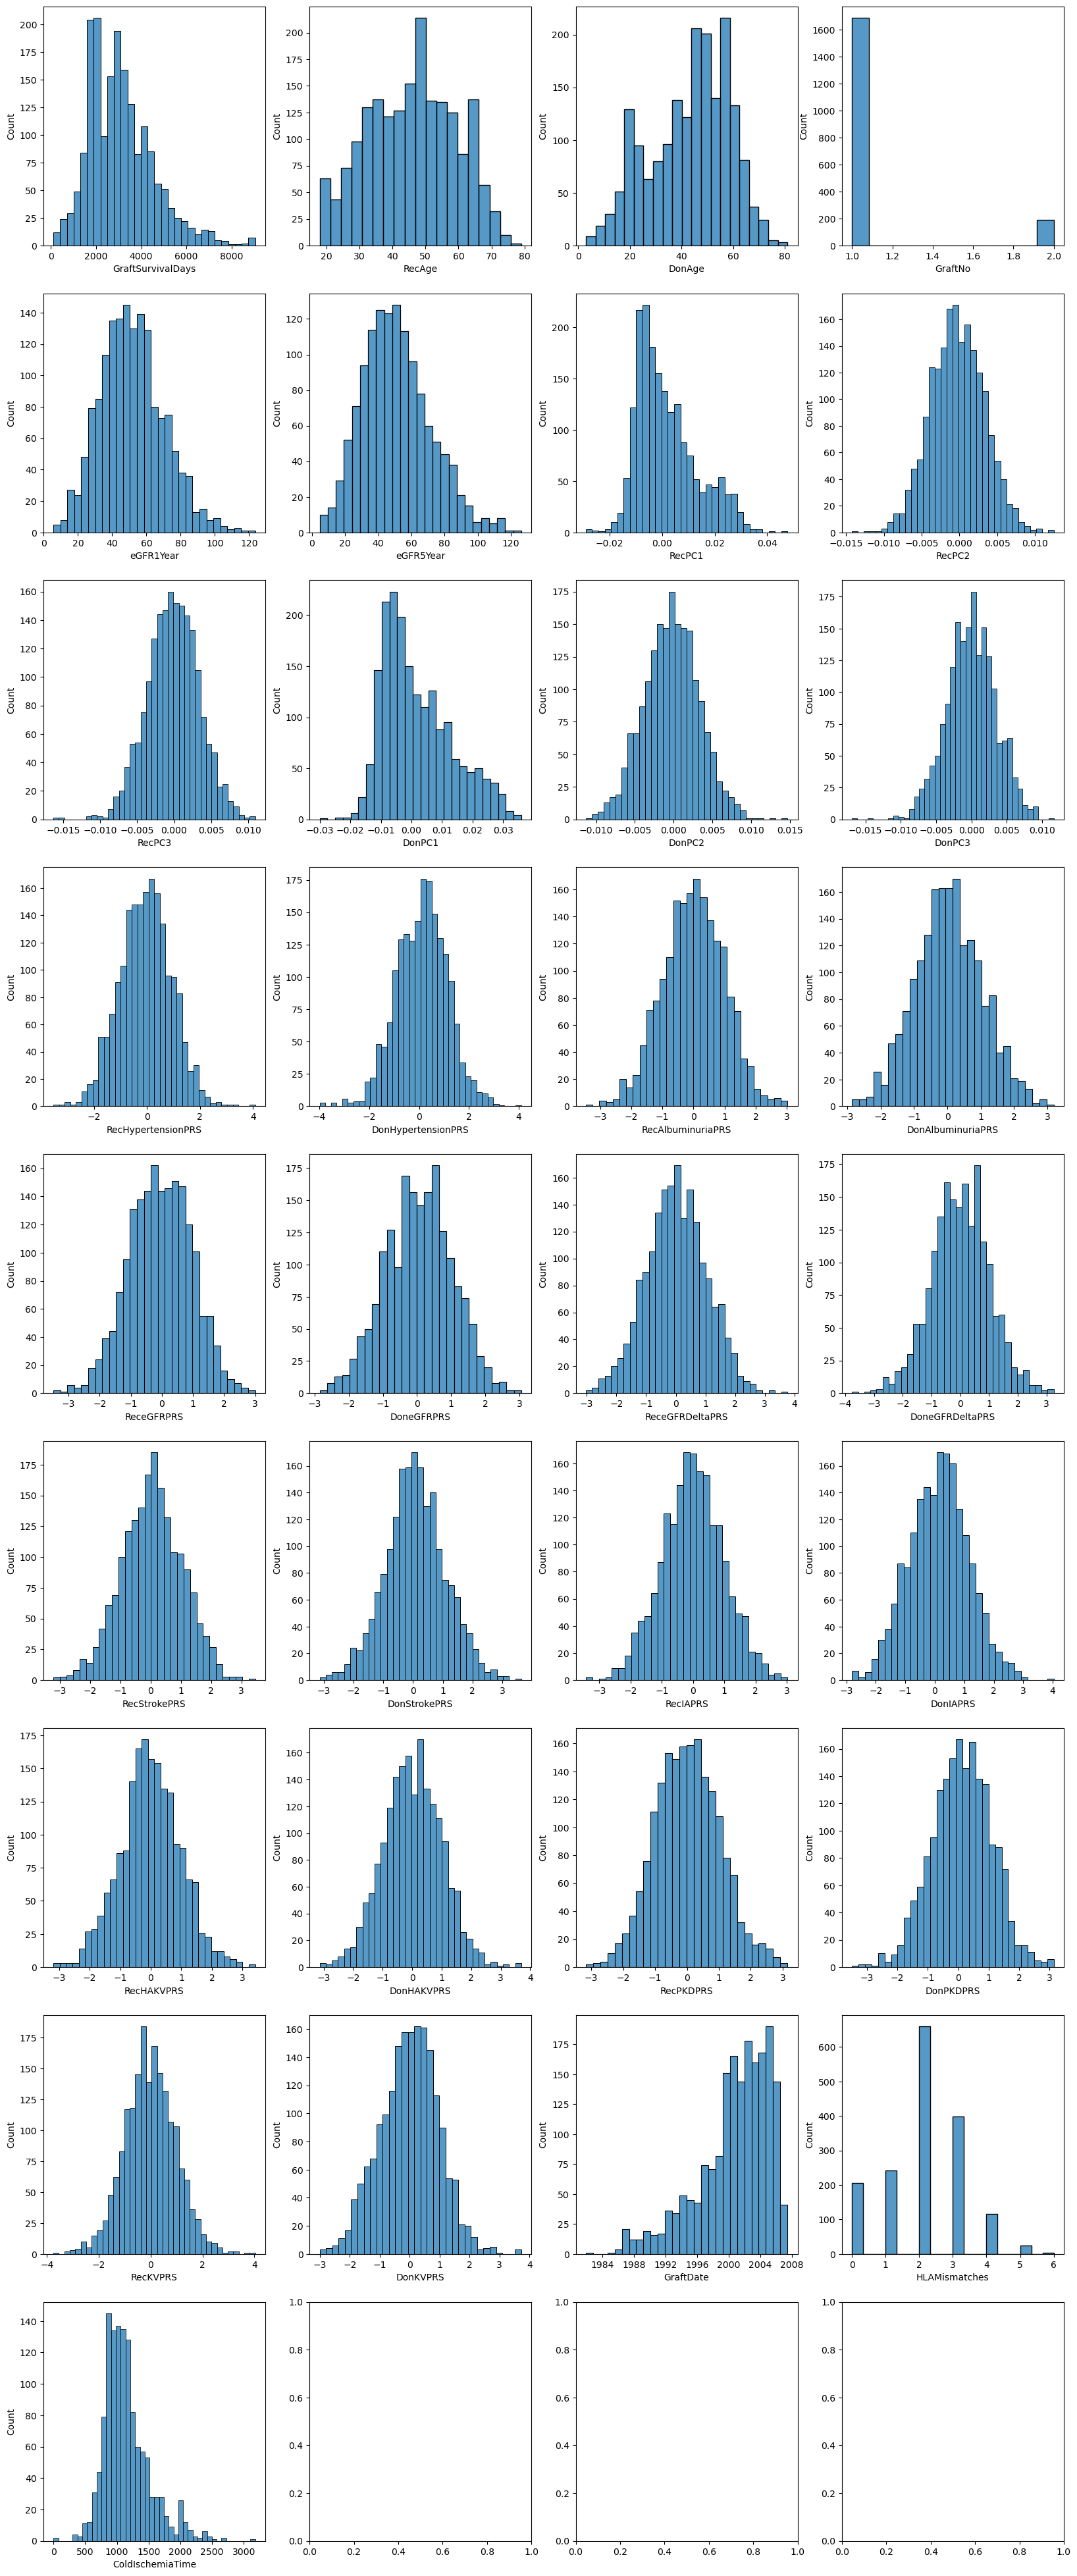

In [ ]:
#| hide
fig, ax = plt.subplots(9,4, figsize=(20, 50))
i = 0
for column in [
    'GraftSurvivalDays', 'RecAge', 'DonAge', 'GraftNo', 
    'eGFR1Year', 'eGFR5Year', 
    'RecPC1', 'RecPC2', 'RecPC3', 'DonPC1', 'DonPC2', 'DonPC3',
    'RecHypertensionPRS', 'DonHypertensionPRS', 'RecAlbuminuriaPRS', 'DonAlbuminuriaPRS',
    'ReceGFRPRS', 'DoneGFRPRS', 'ReceGFRDeltaPRS', 'DoneGFRDeltaPRS', 'RecStrokePRS', 'DonStrokePRS', 
    'RecIAPRS', 'DonIAPRS', 'RecHAKVPRS', 'DonHAKVPRS', 'RecPKDPRS', 'DonPKDPRS', 'RecKVPRS', 'DonKVPRS',
    'GraftDate', 'HLAMismatches', 'ColdIschemiaTime'
]:    
    sns.histplot(data=df_pheno, x=column, ax=ax[i//4, i%4])
    i += 1

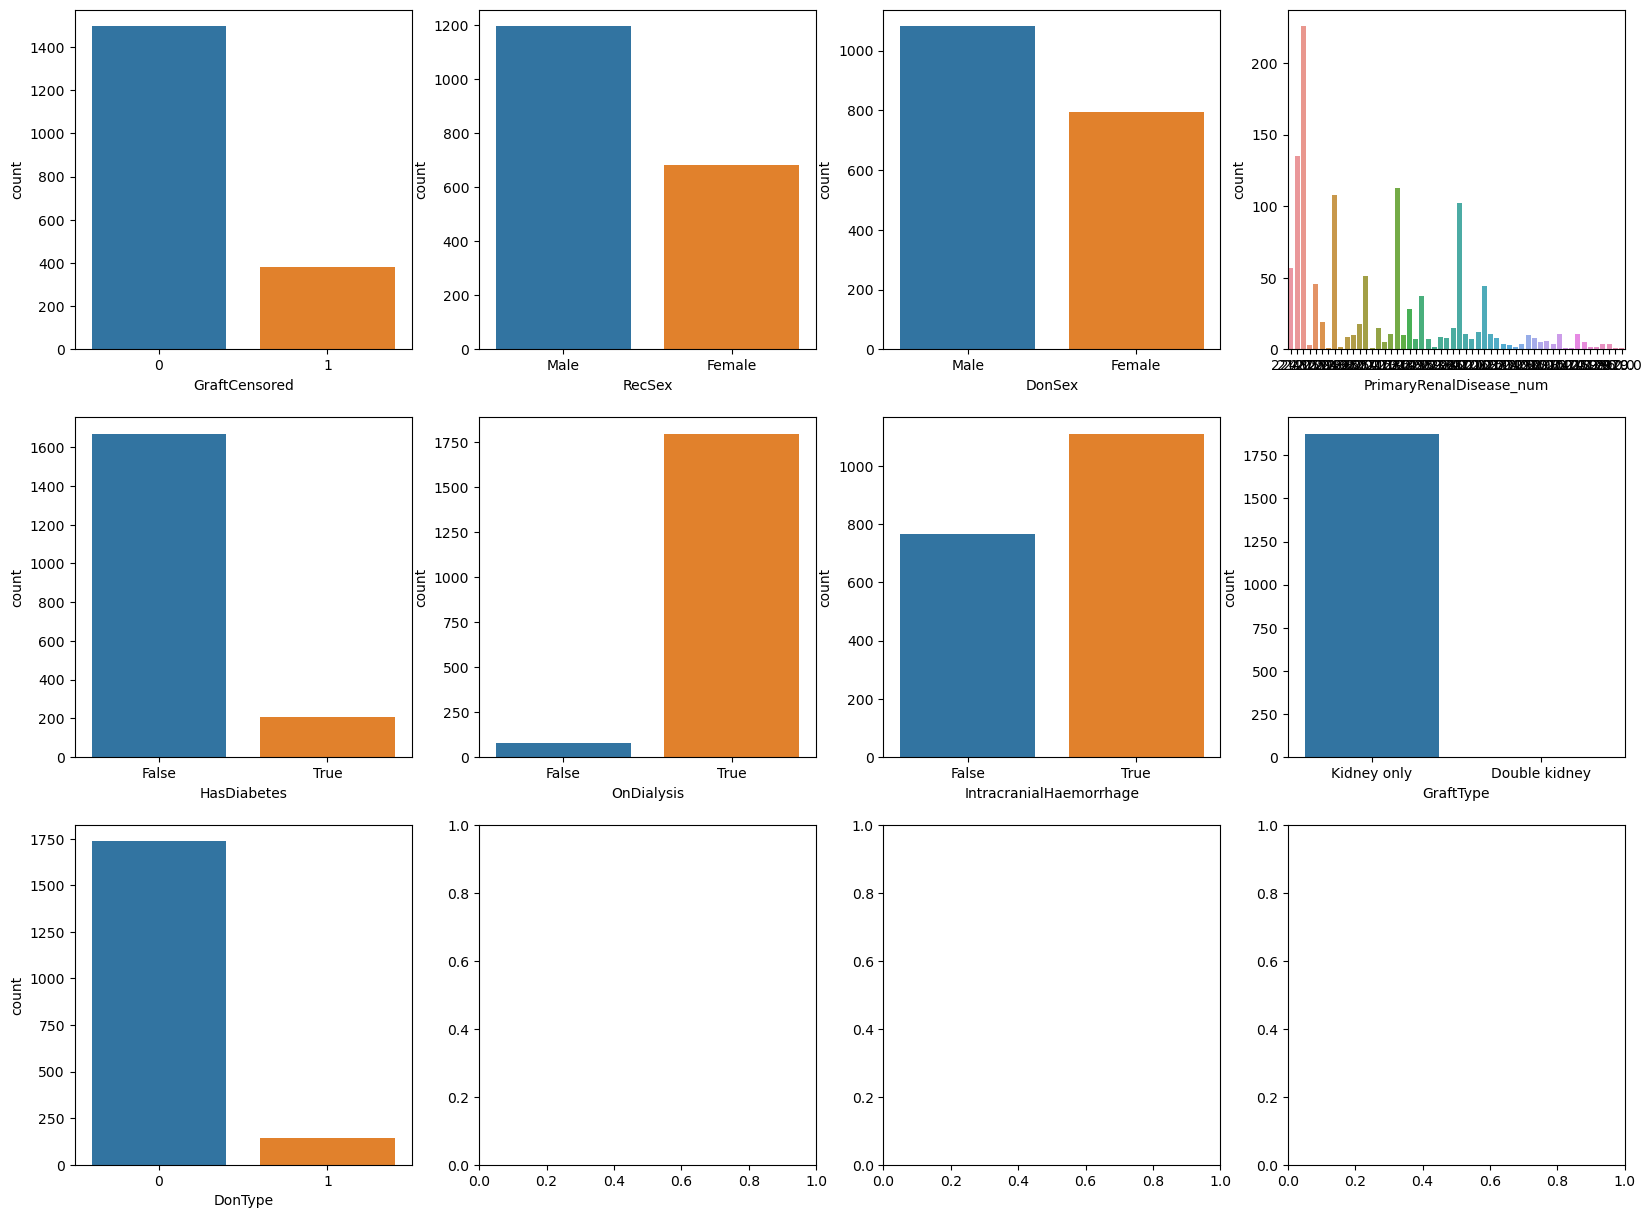

In [ ]:
#| hide 
fig, ax = plt.subplots(3,4, figsize=(20, 15))
i = 0
for column in [
    'GraftCensored', 'RecSex',
    'DonSex', 'PrimaryRenalDisease_num',
    'HasDiabetes', 'OnDialysis', 'IntracranialHaemorrhage', 'GraftType', 
    'DonType'
]:    
    sns.countplot(data=df_pheno, x=column, ax=ax[i//4, i%4])
    i += 1

## Imputation

In [ ]:
#| hide 
df_pheno.isnull().mean()[df_pheno.isnull().mean() > 0] * 100

PrimaryRenalDisease        34.185304
eGFR1Year                  14.110756
eGFR5Year                  30.511182
HLAMismatches              12.087327
ColdIschemiaTime           31.150160
PrimaryRenalDisease_num    34.132055
dtype: float64

<AxesSubplot:>

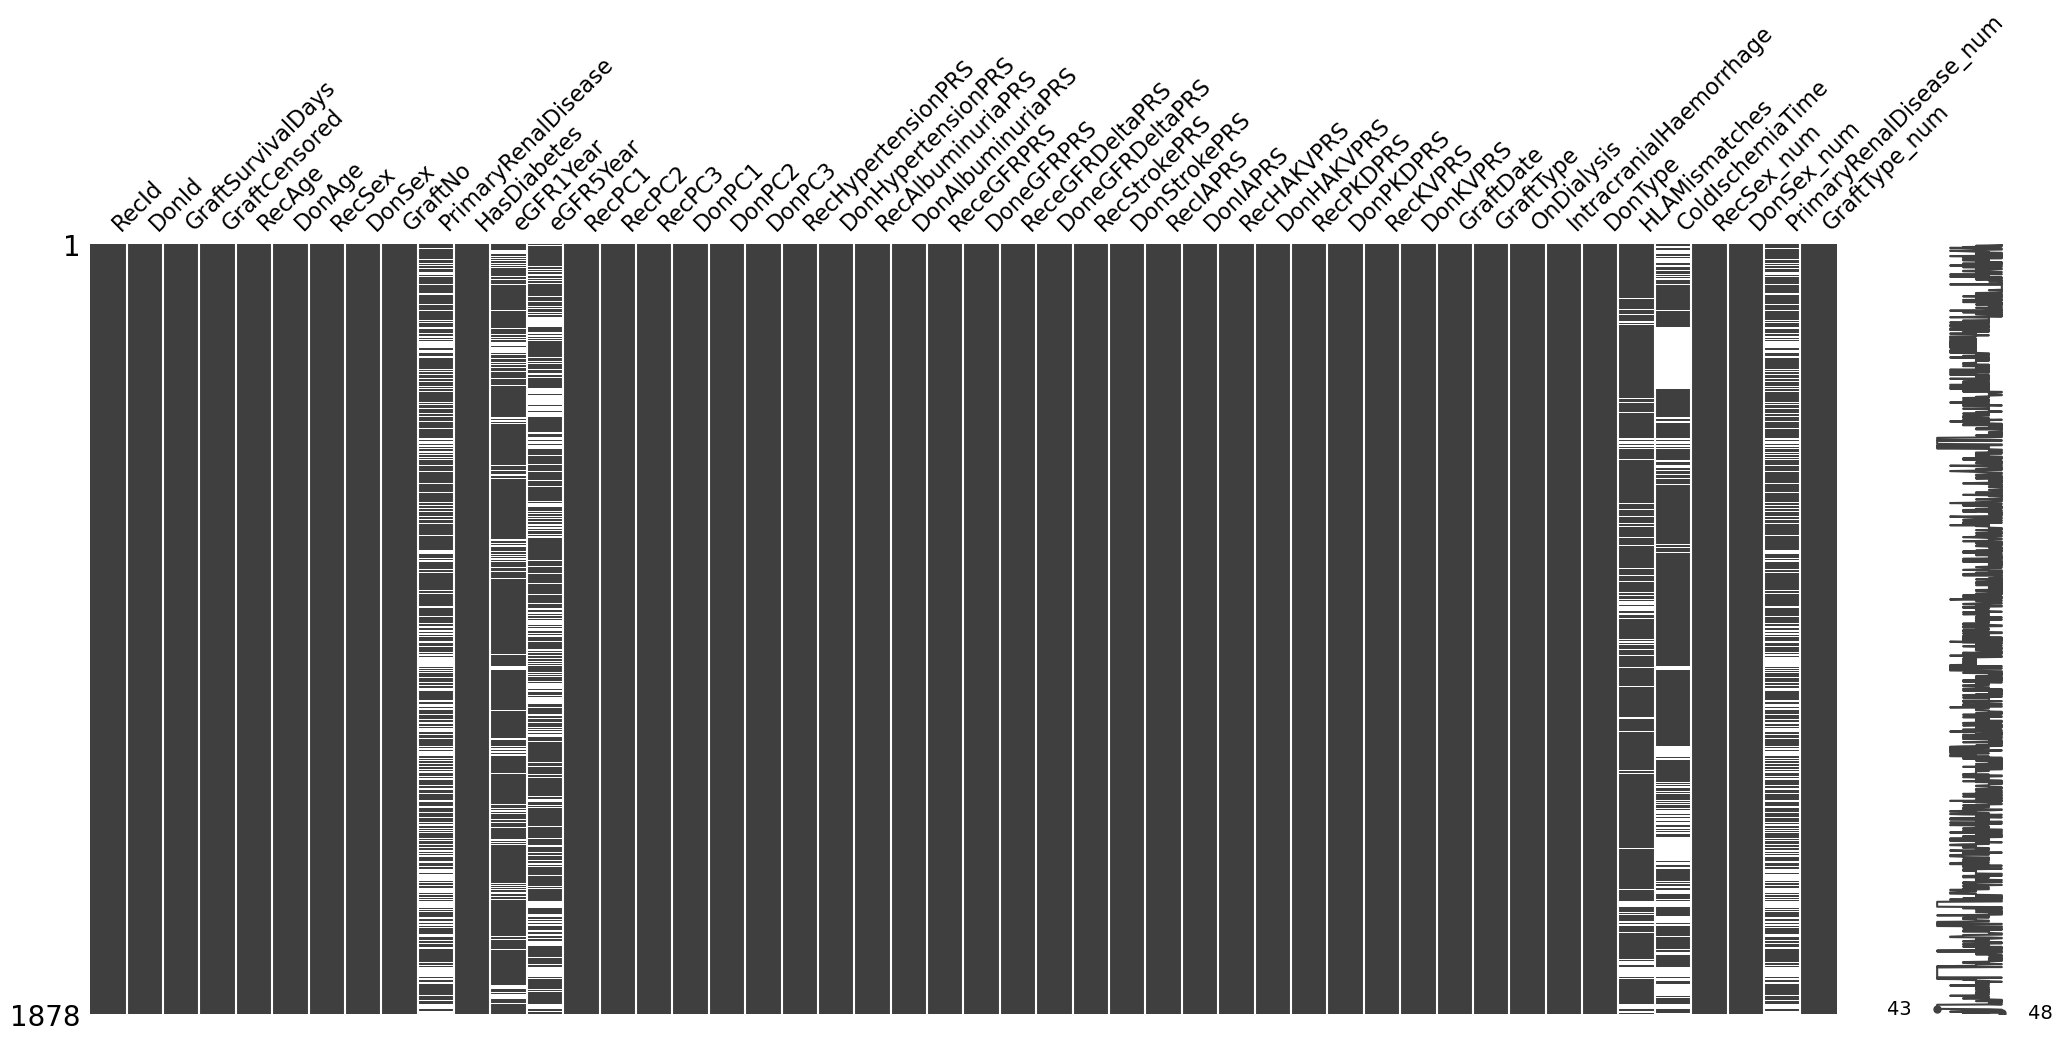

In [ ]:
#| hide
import missingno as msno

msno.matrix(df_pheno)

In [ ]:
#| export
impute_vars = list(df_pheno.isnull().mean()[df_pheno.isnull().mean() > 0].index)
impute_vars = impute_vars[:1] + impute_vars[3:]

The following columns will be imputed

In [ ]:
impute_vars

['PrimaryRenalDisease',
 'HLAMismatches',
 'ColdIschemiaTime',
 'PrimaryRenalDisease_num']

In [ ]:
#| export
df_pheno.to_pickle('data/interim/pheno_r.pkl')

In [ ]:
#| hide 
df_pheno_simple = df_pheno.copy()

In [ ]:
#| hide
features = [ # Determined from EDA (notebook 2)
    'RecAge', 'DonAge', 'RecSex', 'DonSex', 'RecPC1', 
    'RecHypertensionPRS', 'DonHypertensionPRS', 
    'DoneGFRPRS', 'DonStrokePRS', 'RecHAKVPRS', 
    'HLAMismatches', 'ColdIschemiaTime', 'GraftNo', 
    'PrimaryRenalDisease', 'IntracranialHaemorrhage'
]

### Simple Imputer

In [ ]:
#| hide
# create a SimpleImputer object with different strategies for each column
imputer = SimpleImputer(strategy='most_frequent') # for categorical columns
num_imputer = SimpleImputer(strategy='median') # for numerical columns

# impute the PrimaryRenalDisease column using the most frequent value
df_pheno_simple['PrimaryRenalDisease'] = imputer.fit_transform(df_pheno[['PrimaryRenalDisease']])

# encode the PrimaryRenalDisease column as numerical values
le = LabelEncoder()
df_pheno_simple['PrimaryRenalDisease_num'] = le.fit_transform(df_pheno['PrimaryRenalDisease'].astype(str))

# impute the ColdIschemiaTime column using the median value
df_pheno_simple['ColdIschemiaTime'] = num_imputer.fit_transform(df_pheno[['ColdIschemiaTime']])

# impute the OnDialysis column using the most frequent value
df_pheno_simple['HLAMismatches'] = imputer.fit_transform(df_pheno[['HLAMismatches']])


### KNNImputer

In [ ]:
#| hide
# Convert the 'PrimaryRenalDisease' column to categorical data
le = LabelEncoder()
df_pheno_knn['PrimaryRenalDisease'] = le.fit_transform(df_pheno_knn['PrimaryRenalDisease'].astype(str))

# Create the KNN imputer object
imputer = KNNImputer(n_neighbors=5)

# Impute the missing values in the selected columns
imputed_data = imputer.fit_transform(df_pheno_knn[impute_vars])
df_pheno_knn[impute_vars] = imputed_data

# Convert the 'PrimaryRenalDisease' column back to object data
df_pheno_knn['PrimaryRenalDisease'] = le.inverse_transform(imputed_data[:, 0].astype(int))


## Imputation Evaluation

### Visual

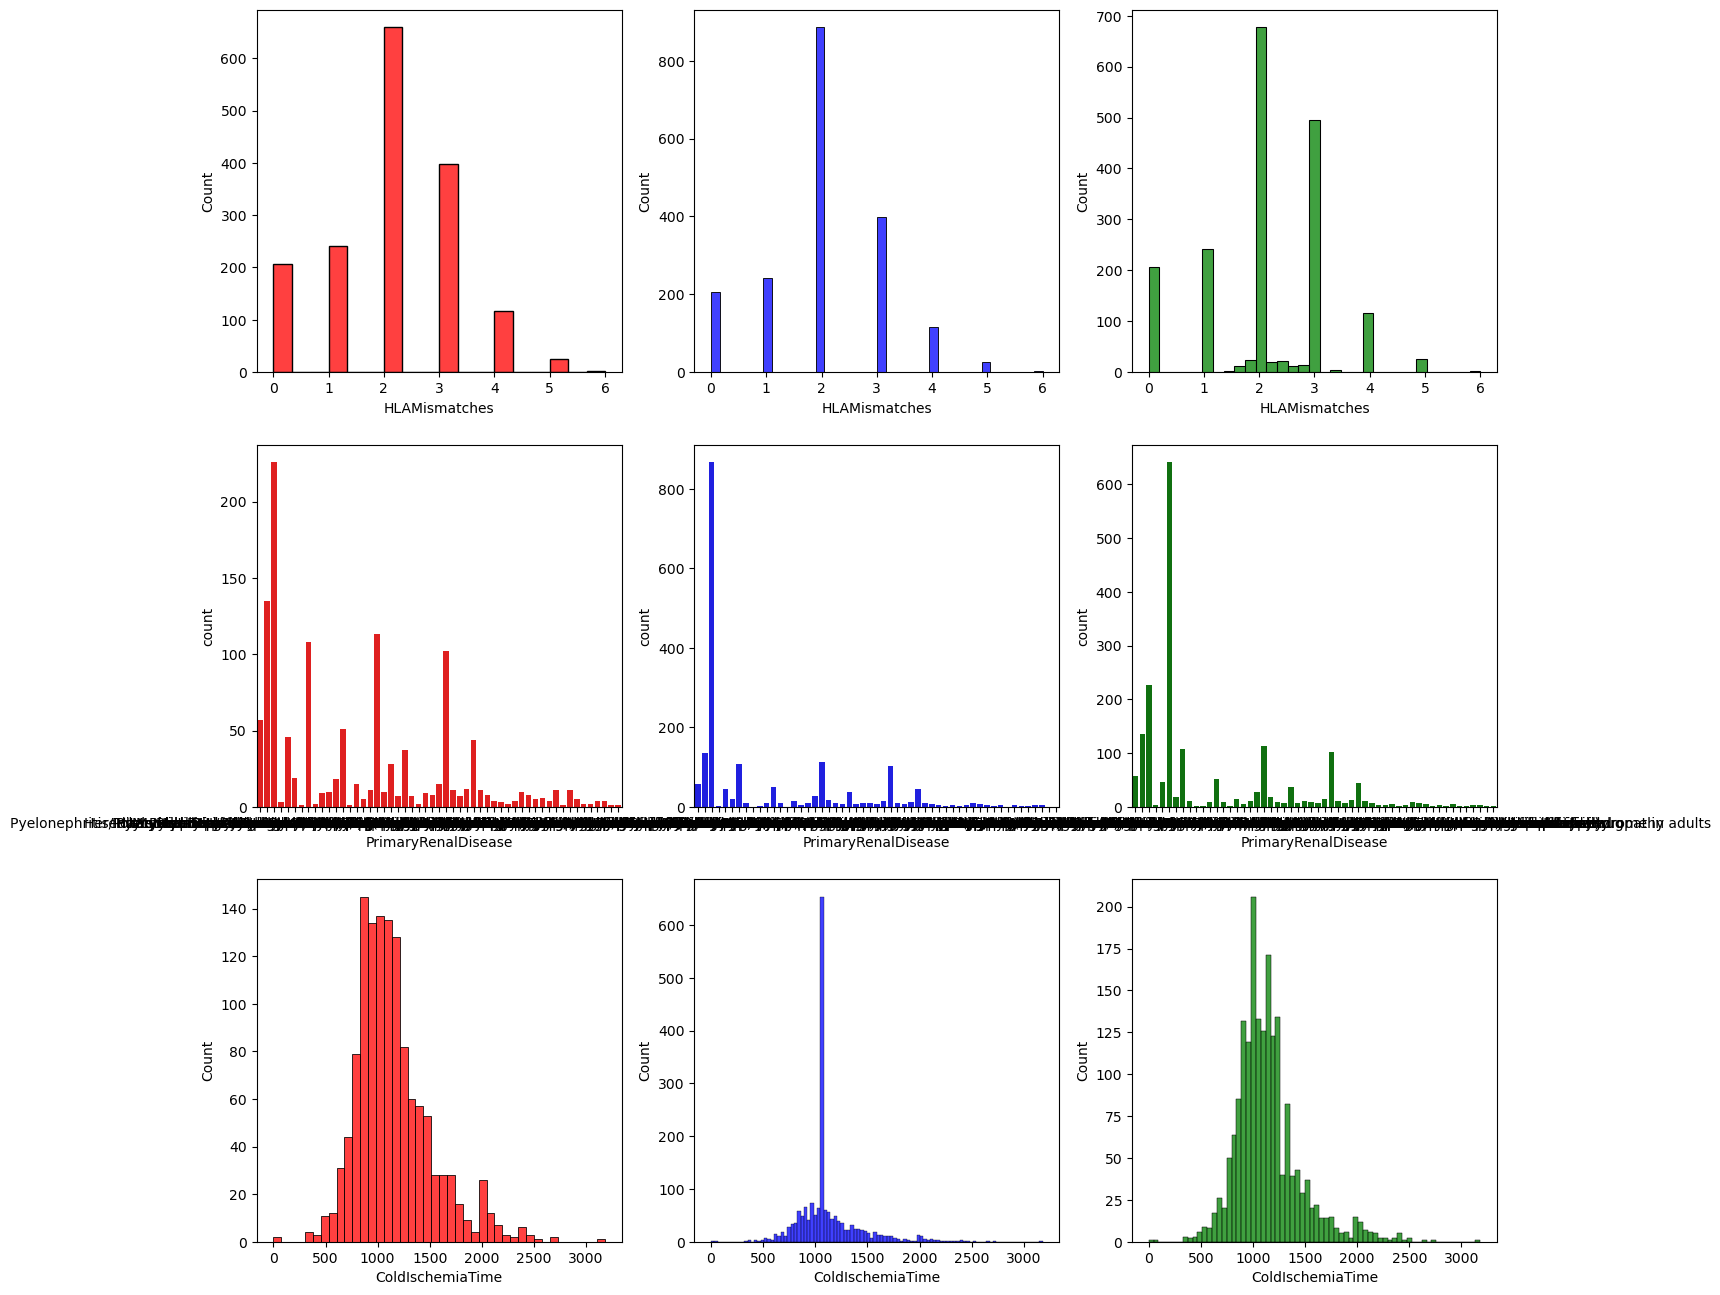

In [ ]:
#| hide
fig, ax = plt.subplots(3, 3, figsize=(16, 16))

# HasDiabetes
x = 'HLAMismatches'
h1 = sns.histplot(data=df_pheno, x=x, color='red', ax=ax[0,0])
h2 = sns.histplot(data=df_pheno_simple, x=x, color='blue', ax=ax[0,1])
h3 = sns.histplot(data=df_pheno_knn, x=x, color='green', ax=ax[0,2])

# PrimaryRenalDisease
x = 'PrimaryRenalDisease'
p1 = sns.countplot(data=df_pheno, x=x, color='red', ax=ax[1,0])
p2 = sns.countplot(data=df_pheno_simple, x=x, color='blue', ax=ax[1,1])
p3 = sns.countplot(data=df_pheno_knn, x=x, color='green', ax=ax[1,2])

# ColdIschemiaTime
x = 'ColdIschemiaTime'
c1 = sns.histplot(data=df_pheno, x=x, color='red', ax=ax[2,0])
c2 = sns.histplot(data=df_pheno_simple, x=x, color='blue', ax=ax[2,1])
c3 = sns.histplot(data=df_pheno_knn, x=x, color='green', ax=ax[2,2]);

### Statistical

In [ ]:
#| hide 
df_pheno[impute_vars]

,PrimaryRenalDisease,HLAMismatches,ColdIschemiaTime,PrimaryRenalDisease_num
0,Pyelonephritis/Interstitial nephritis due to V...,1.0,1080.0,36
1,IgA nephropathy,2.0,1110.0,19
2,"Polycystic kidneys, adult type (dominant type)",4.0,1102.0,32
3,Myelomatosis/Light chain deposit disease,2.0,740.0,26
4,IgA nephropathy,3.0,1080.0,19
...,...,...,...,...
2098,"Polycystic kidneys, adult type (dominant type)",1.0,1380.0,32
2100,"Polycystic kidneys, adult type (dominant type)",2.0,1235.0,32
2101,Diabetes - non-insulin dependent (Type II),2.0,1080.0,7
2102,"Polycystic kidneys, adult type (dominant type)",3.0,1080.0,32


In [ ]:
#| hide
# Loop through the columns and perform statistical tests
for col in impute_vars[:-1]:
    # Check if the column is categorical or numeric
    if df_pheno[col].dtype != 'float':
        # If categorical, perform a chi-square test
        contingency_table = pd.crosstab(df_pheno[col], df_pheno_simple[col])
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        print(f'{col}: Chi-square test p-value for Simple = {p_value}')
        contingency_table = pd.crosstab(df_pheno[col], df_pheno_knn[col])
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        print(f'{col}: Chi-square test p-value for KNN = {p_value}')
    else:
        # If numeric, perform a t-test
        t_statistic, p_value = ttest_ind(df_pheno[col].dropna(), df_pheno_simple[col])
        print(f'{col}: T-test p-value for Simple = {p_value}')
        t_statistic, p_value = ttest_ind(df_pheno[col].dropna(), df_pheno_knn[col])
        print(f'{col}: T-test p-value for KNN = {p_value}')

NameError: name 'impute_vars' is not defined

## Result

In [ ]:
msno.matrix(df_pheno);

## Export

In [ ]:
# export to pickle
#df_pheno.to_pickle('data/proc/pheno.pkl')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()